# Machine Translation With Transformers
Created by Paul Scott<br>
Last updated August 23<sup>rd</sup>, 2022

### References
* https://www.tensorflow.org/text/tutorials/nmt_with_attention
* https://www.tensorflow.org/text/tutorials/transformer

# Setup

### Install Packages

In [ ]:
%%capture
%pip install stanza

### Imports

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers, losses, metrics, callbacks
import matplotlib.pyplot as plt
from collections import Counter
from IPython import display
import numpy as np
import pandas as pd
import stanza
import pickle
import time
import re
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Helper Functions

In [5]:
language_codes = {
  'arabic': 'ar', 'chinese': 'zh', 'dutch': 'nl', 'english': 'en',
  'french': 'fr', 'german': 'de', 'greek': 'el', 'hindi': 'hi',
  'italian': 'it', 'japanese': 'ja', 'korean': 'ko', 'portuguese': 'pt',
  'romanian': 'ro', 'russian': 'ru', 'spanish': 'es', 'ukrainian': 'uk'
}


def save_layer_as_pickle(obj, file):
  pkl = {'config': obj.get_config(), 'weights': obj.get_weights()}
  pickle.dump(pkl, open(file, 'wb'))


def load_pickle_as_layer(file, layer_type):
  pkl = pickle.load(open(file, 'rb'))
  vectorizer = layer_type.from_config(pkl['config'])
  vectorizer.set_weights(pkl['weights'])
  return vectorizer


def make_dir(dir):
  if not os.path.isdir(dir):
      os.makedirs(dir)

### Set Environment Directory

In [6]:
# use google drive or local environment
try:
  from google.colab import output
  output.enable_custom_widget_manager()
  env_dir = 'drive/MyDrive/colab_envs/transformer_translation'
except:
  env_dir = '.'

# Preprocessing

### Load Sentence Pairs

In [11]:
language = 'portuguese'
invert = False

input_language = language if invert else 'english'
target_language = 'english' if invert else language

with open(f'{env_dir}/sentence_pairs/{language}.txt', 'r') as f:
  sentence_pairs = [tuple(line.split('\t')[:2]) for line in f.readlines()]

input_index = 1 if invert else 0
target_index = 0 if invert else 1

# split sentence pairs into inputs and targets
inputs = [sentence_pair[input_index] for sentence_pair in sentence_pairs]
targets = [sentence_pair[target_index] for sentence_pair in sentence_pairs]

### Show Sample Sentence Pairs

In [12]:
example_inputs, example_targets = [], []
for _ in range(10):
  rand_index = np.random.randint(len(inputs))
  example_inputs.append(inputs[rand_index])
  example_targets.append(targets[rand_index])

pd.DataFrame({input_language: example_inputs, target_language: example_targets})

,english,portuguese
0,I spent all day working yesterday.,Ontem fiquei trabalhando o dia inteiro.
1,Do you think I should go alone?,Você acha que eu deveria ir sozinho?
2,Your reputation precedes you.,Você faz jus à sua reputação.
3,Tom does that when he's sleepy.,O Tom faz isso quando ele está com sono.
4,The bear caught a salmon in the river and ate it.,O urso pegou um salmão no rio e o comeu.
5,"Probably, it'll snow tomorrow.",Provavelmente vai nevar amanhã.
6,We have two kids.,Temos dois filhos.
7,Have you made up your mind about what you're g...,As senhoras já estão certas a respeito do pres...
8,You're free to talk with anyone.,Você pode conversar com quem quiser.
9,He went down the hill.,Ele desceu o morro.


### Tokenize Sentences

In [13]:
def tokenize(tokenizer, sentences, return_vocab_size=False, add_start_end=False):
  docs = [stanza.Document([], text=s) for s in sentences]
  tokenized = tokenizer(docs)
  tokenized = [[token.text.lower() for token in tokens.iter_tokens()] for tokens in tokenized]

  if add_start_end:
    tokenized = [['[START]'] + tokens + ['[END]'] for tokens in tokenized]
  
  if return_vocab_size:
    token_counter = Counter()
    for tokens in tokenized:
      for token in tokens:
        token_counter[token] += 1

  tokenized = [' '.join(tokens) for tokens in tokenized]

  if return_vocab_size:
    return tokenized, len(token_counter) + 2
  else:
    return tokenized



input_language_code = language_codes[language if invert else 'english']
target_language_code = language_codes['english' if invert else language]

# download stanza data
stanza.download(input_language_code)
stanza.download(target_language_code)

# create tokenizers
input_tokenizer = stanza.Pipeline(lang=input_language_code, processors='tokenize')
target_tokenizer = stanza.Pipeline(lang=target_language_code, processors='tokenize')

# tokenize sentence pairs
inputs_tokenized, input_vocab_size = tokenize(input_tokenizer, inputs, return_vocab_size=True)
targets_tokenized, target_vocab_size = tokenize(target_tokenizer, targets, return_vocab_size=True, add_start_end=True)

2022-08-25 17:12:08 INFO: Downloading default packages for language: en (English)...
2022-08-25 17:12:10 INFO: File exists: /Users/paulscott/stanza_resources/en/default.zip.
2022-08-25 17:12:13 INFO: Finished downloading models and saved to /Users/paulscott/stanza_resources.
2022-08-25 17:12:13 INFO: Downloading default packages for language: pt (Portuguese)...
2022-08-25 17:12:30 INFO: Finished downloading models and saved to /Users/paulscott/stanza_resources.
2022-08-25 17:12:30 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2022-08-25 17:12:30 INFO: Use device: cpu
2022-08-25 17:12:30 INFO: Loading: tokenize
2022-08-25 17:12:30 INFO: Done loading processors!
2022-08-25 17:12:30 WARNING: Language pt package default expects mwt, which has been added
2022-08-25 17:12:30 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package |
-----------------------
| tokenize  | bosque  |
| mwt

### Create Text Processors

In [ ]:
# define text vectorization layers
input_vectorizer = layers.TextVectorization(input_vocab_size, standardize=None)
target_vectorizer = layers.TextVectorization(target_vocab_size, standardize=None)

# adapt vectorizers to inputs and targets
input_vectorizer.adapt(inputs_tokenized)
target_vectorizer.adapt(targets_tokenized)

# define target index to token mapping layer
target_token_from_index = layers.StringLookup(vocabulary=target_vectorizer.get_vocabulary(), mask_token='', invert=True)

### Create Train And Test Sets



In [ ]:
batch_size = 128
train_test_split = 0.9

dataset = tf.data.Dataset.from_tensor_slices((inputs_tokenized, targets_tokenized))

train_size = int(len(dataset) * train_test_split)
test_size = len(dataset) - train_size

train_dataset = dataset.take(train_size).shuffle(train_size, reshuffle_each_iteration=True).batch(batch_size)
test_dataset = dataset.skip(train_size).shuffle(test_size, reshuffle_each_iteration=True).batch(batch_size)

# Model Functions

In [ ]:
def create_transformer(num_layers, num_heads, embedding_dim, ff_dim,
                       input_vocab_size, target_vocab_size,
                       dropout_rate=0.1, max_tokens=128):
  input_tokens = keras.Input(shape=(None,), dtype=tf.int64, name='input_tokens')
  target_tokens = keras.Input(shape=(None,), dtype=tf.int64, name='target_tokens')

  padding_mask, look_ahead_mask = create_masks(input_tokens, target_tokens)

  encoder_out = encoder(input_tokens, padding_mask, num_layers, num_heads,
                        embedding_dim, ff_dim, input_vocab_size, dropout_rate, max_tokens)
  
  decoder_out, attentions = decoder(target_tokens, encoder_out, look_ahead_mask, padding_mask,
                                    num_layers, num_heads, embedding_dim, ff_dim,
                                    target_vocab_size, dropout_rate, max_tokens)
  
  out = layers.Dense(target_vocab_size)(decoder_out)

  transformer = keras.Model(inputs=[input_tokens, target_tokens], outputs=[out, attentions])

  return transformer


def encoder(x, padding_mask, num_layers, num_heads, 
            embedding_dim, ff_dim, vocab_size,
            dropout_rate, max_tokens):
  seq_len = tf.shape(x)[1]

  x = layers.Embedding(vocab_size, embedding_dim)(x)
  x *= tf.math.sqrt(tf.cast(embedding_dim, tf.float32))
  x += positional_encoding(max_tokens, embedding_dim)[:, :seq_len, :]

  x = layers.Dropout(dropout_rate)(x)

  for i in range(num_layers):
    x = encoder_layer(x, padding_mask, num_heads, embedding_dim, ff_dim, dropout_rate)
  
  return x


def decoder(x, encoder_out, look_ahead_mask, padding_mask,
            num_layers, num_heads, embedding_dim, ff_dim, vocab_size,
            dropout_rate, max_tokens):  
  seq_len = tf.shape(x)[1]
  attentions = []

  x = layers.Embedding(vocab_size, embedding_dim)(x)
  x *= tf.math.sqrt(tf.cast(embedding_dim, tf.float32))
  x += positional_encoding(max_tokens, embedding_dim)[:, :seq_len, :]

  x = layers.Dropout(dropout_rate)(x)

  for i in range(num_layers):
    x, attn = decoder_layer(x, encoder_out, look_ahead_mask, padding_mask,
                            num_heads, embedding_dim, ff_dim, dropout_rate)
    attentions.append(attn)

  return x, attentions


def encoder_layer(x, padding_mask, num_heads, embedding_dim, ff_dim, dropout_rate):
  x, _ = multi_head_attention(x, x, padding_mask, num_heads, embedding_dim, dropout_rate)
  x = feed_forward(x, embedding_dim, ff_dim, dropout_rate)
  return x


def decoder_layer(x, encoder_out, look_ahead_mask, padding_mask, num_heads, embedding_dim, ff_dim, dropout_rate):
  x, _ = multi_head_attention(x, x, look_ahead_mask, num_heads, embedding_dim, dropout_rate)
  x, attn = multi_head_attention(x, encoder_out, padding_mask, num_heads, embedding_dim, dropout_rate)
  x = feed_forward(x, embedding_dim, ff_dim, dropout_rate)
  return x, attn


def multi_head_attention(q, k, mask, num_heads, embedding_dim, dropout_rate):
  mha_out, attn = layers.MultiHeadAttention(num_heads, embedding_dim)(q, k, attention_mask=mask, return_attention_scores=True)
  mha_out = layers.Dropout(dropout_rate)(mha_out)
  mha_out = layers.LayerNormalization(epsilon=1e-6)(q + mha_out)
  return mha_out, attn


def feed_forward(x, embedding_dim, ff_dim, dropout_rate):
  ff_out = layers.Dense(ff_dim, activation='relu')(x)
  ff_out = layers.Dense(embedding_dim)(ff_out)
  ff_out = layers.Dropout(dropout_rate)(ff_out)
  ff_out = layers.LayerNormalization(epsilon=1e-6)(x + ff_out)
  return ff_out


def positional_encoding(position, embedding_dim):
  position_range = np.arange(position)[:, np.newaxis]
  i = np.arange(embedding_dim)[np.newaxis, :]

  angle_rads = position_range / (np.power(10000, (2 * (i // 2)) / np.float32(embedding_dim)))
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]
  
  return tf.cast(pos_encoding, dtype=tf.float32)


def create_masks(input_tokens, target_tokens):
  padding_mask = create_padding_mask(input_tokens)
  look_ahead_mask = create_look_ahead_mask(tf.shape(target_tokens)[1])
  
  target_padding_mask = create_padding_mask(target_tokens)
  look_ahead_mask = tf.minimum(target_padding_mask, look_ahead_mask)

  return padding_mask, look_ahead_mask


def create_padding_mask(seq):
  return tf.cast(tf.math.logical_not(tf.math.equal(seq, 0)), tf.float32)[:, tf.newaxis, tf.newaxis, :]


def create_look_ahead_mask(size):
  n = tf.cast(size * (size+1) / 2, dtype=tf.int32)
  return tfp.math.fill_triangular(tf.ones((n,), dtype=tf.float32), upper=False)

# Training

### Define Training Functions

In [ ]:
global transformer, sparse_cce_loss, optimizer, train_loss_mean, test_loss_mean, train_accuracy_mean, test_accuracy_mean

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


def train(epochs, restore_epoch=0, plot_freq=50, save_freq=5):
  train_losses, train_accuracies = [], []
  test_losses, test_accuracies = [], []
  avg_batch_time = 0
  completed_batches = 0
  total_batches = epochs * len(train_dataset)

  test_dataset_iter = test_dataset.as_numpy_iterator()
  
  for epoch in range(epochs):

    train_loss_mean.reset_states()
    test_loss_mean.reset_states()
    train_accuracy_mean.reset_states()
    test_accuracy_mean.reset_states()

    for i, (input_batch, target_batch) in enumerate(train_dataset):
      start = time.time()

      input_batch = input_vectorizer(input_batch)
      target_batch = target_vectorizer(target_batch)

      try:
        test_input_batch, test_target_batch = test_dataset_iter.next()
      except:
        test_dataset_iter = test_dataset.as_numpy_iterator()
        test_input_batch, test_target_batch = test_dataset_iter.next()

      test_input_batch = input_vectorizer(test_input_batch)
      test_target_batch = target_vectorizer(test_target_batch)

      train_loss, train_accuracy = train_step(input_batch, target_batch)
      test_loss, test_accuracy = test_step(test_input_batch, test_target_batch)

      train_loss_mean(train_loss)
      test_loss_mean(test_loss)
      train_accuracy_mean(train_accuracy)
      test_accuracy_mean(test_accuracy)

      train_losses.append(train_loss)
      test_losses.append(test_loss)
      train_accuracies.append(train_accuracy)
      test_accuracies.append(test_accuracy)

      if i % plot_freq == 0:
        display.clear_output(wait=True)
        plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

      remaining_time, avg_batch_time = get_remaining_time(start, completed_batches, total_batches, avg_batch_time, restore_epoch)
      completed_batches += 1

      epoch_str = f'\rEpoch {epoch+1} of {epochs} | '
      epoch_str += f'Progress: {i+1}/{len(train_dataset)} | '
      epoch_str += f'Train Loss: {train_loss_mean.result():.3f} | '
      epoch_str += f'Train Accuracy: {(train_accuracy_mean.result()*100):.3f}% | '
      epoch_str += f'Test Loss: {test_loss_mean.result():.3f} | '
      epoch_str += f'Test Accuracy: {(test_accuracy_mean.result()*100):.3f}% | '
      epoch_str += f'Remaining Time: {remaining_time}        '
      
      print(epoch_str, end='')
  
  return train_losses, test_losses, train_accuracies, test_accuracies


@tf.function(input_signature=train_step_signature)
def train_step(inputs, targets):
  targets_in = targets[:, :-1]
  targets_real = targets[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inputs, targets_in], training=True)
    loss = transformer_loss(targets_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  return loss, accuracy(targets_real, predictions)


@tf.function(input_signature=train_step_signature)
def test_step(inputs, targets):
  targets_in = targets[:, :-1]
  targets_real = targets[:, 1:]
  
  predictions, _ = transformer([inputs, targets_in], training=False)
  loss = transformer_loss(targets_real, predictions)
  return loss, accuracy(targets_real, predictions)


def transformer_loss(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss = sparse_cce_loss(real, pred)
  
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  return tf.reduce_sum(loss) / tf.reduce_sum(mask)


def accuracy(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  
  return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)


def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

  ax1.set_title('Loss vs. Batch #')
  ax1.set_xlabel('Batch #')
  ax1.set_ylabel('Loss')
  ax1.plot(train_losses)
  ax1.plot(test_losses)
  ax1.legend(['Train', 'Test'])

  ax2.set_title('Accuracy vs. Batch #')
  ax2.set_xlabel('Batch #')
  ax2.set_ylabel('Accuracy')
  ax2.plot(train_accuracies)
  ax2.plot(test_accuracies)
  ax2.legend(['Train', 'Test'])
  
  plt.show()


def get_remaining_time(batch_start, batch, total_batches, avg_batch_time, restore_epoch):
  time_for_epoch = time.time() - batch_start
  batch_adj = batch - restore_epoch * 64
  avg_batch_time = (avg_batch_time * batch_adj + time_for_epoch) / (batch_adj + 1)
  remaining_batches = total_batches - (batch + 1)
  
  remaining_time = get_time_string(remaining_batches * avg_batch_time)

  return remaining_time, avg_batch_time


def get_time_string(total_seconds):
  hours = int(total_seconds // 3600)
  remainder = total_seconds % 3600
  minutes = int(remainder // 60)
  seconds = round(remainder % 60, 2)
  time_string = ''
  if hours > 0:
    time_string += f'{hours}h '
  if remainder >= 60:
    time_string += f'{minutes}m '
  time_string += f'{seconds}s'
  return time_string

### Create Transformer And Configure Training

In [ ]:
epochs = 5

num_layers = 3
embedding_dim = 512
ff_dim = 512
num_heads = 8

sparse_cce_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

train_loss_mean = metrics.Mean()
train_accuracy_mean = metrics.Mean()
test_loss_mean = metrics.Mean()
test_accuracy_mean = metrics.Mean()

model_name = f'{input_language}_to_{target_language}'

transformer = create_transformer(num_layers, num_heads, embedding_dim, ff_dim, input_vocab_size, target_vocab_size)

### Train Transformer

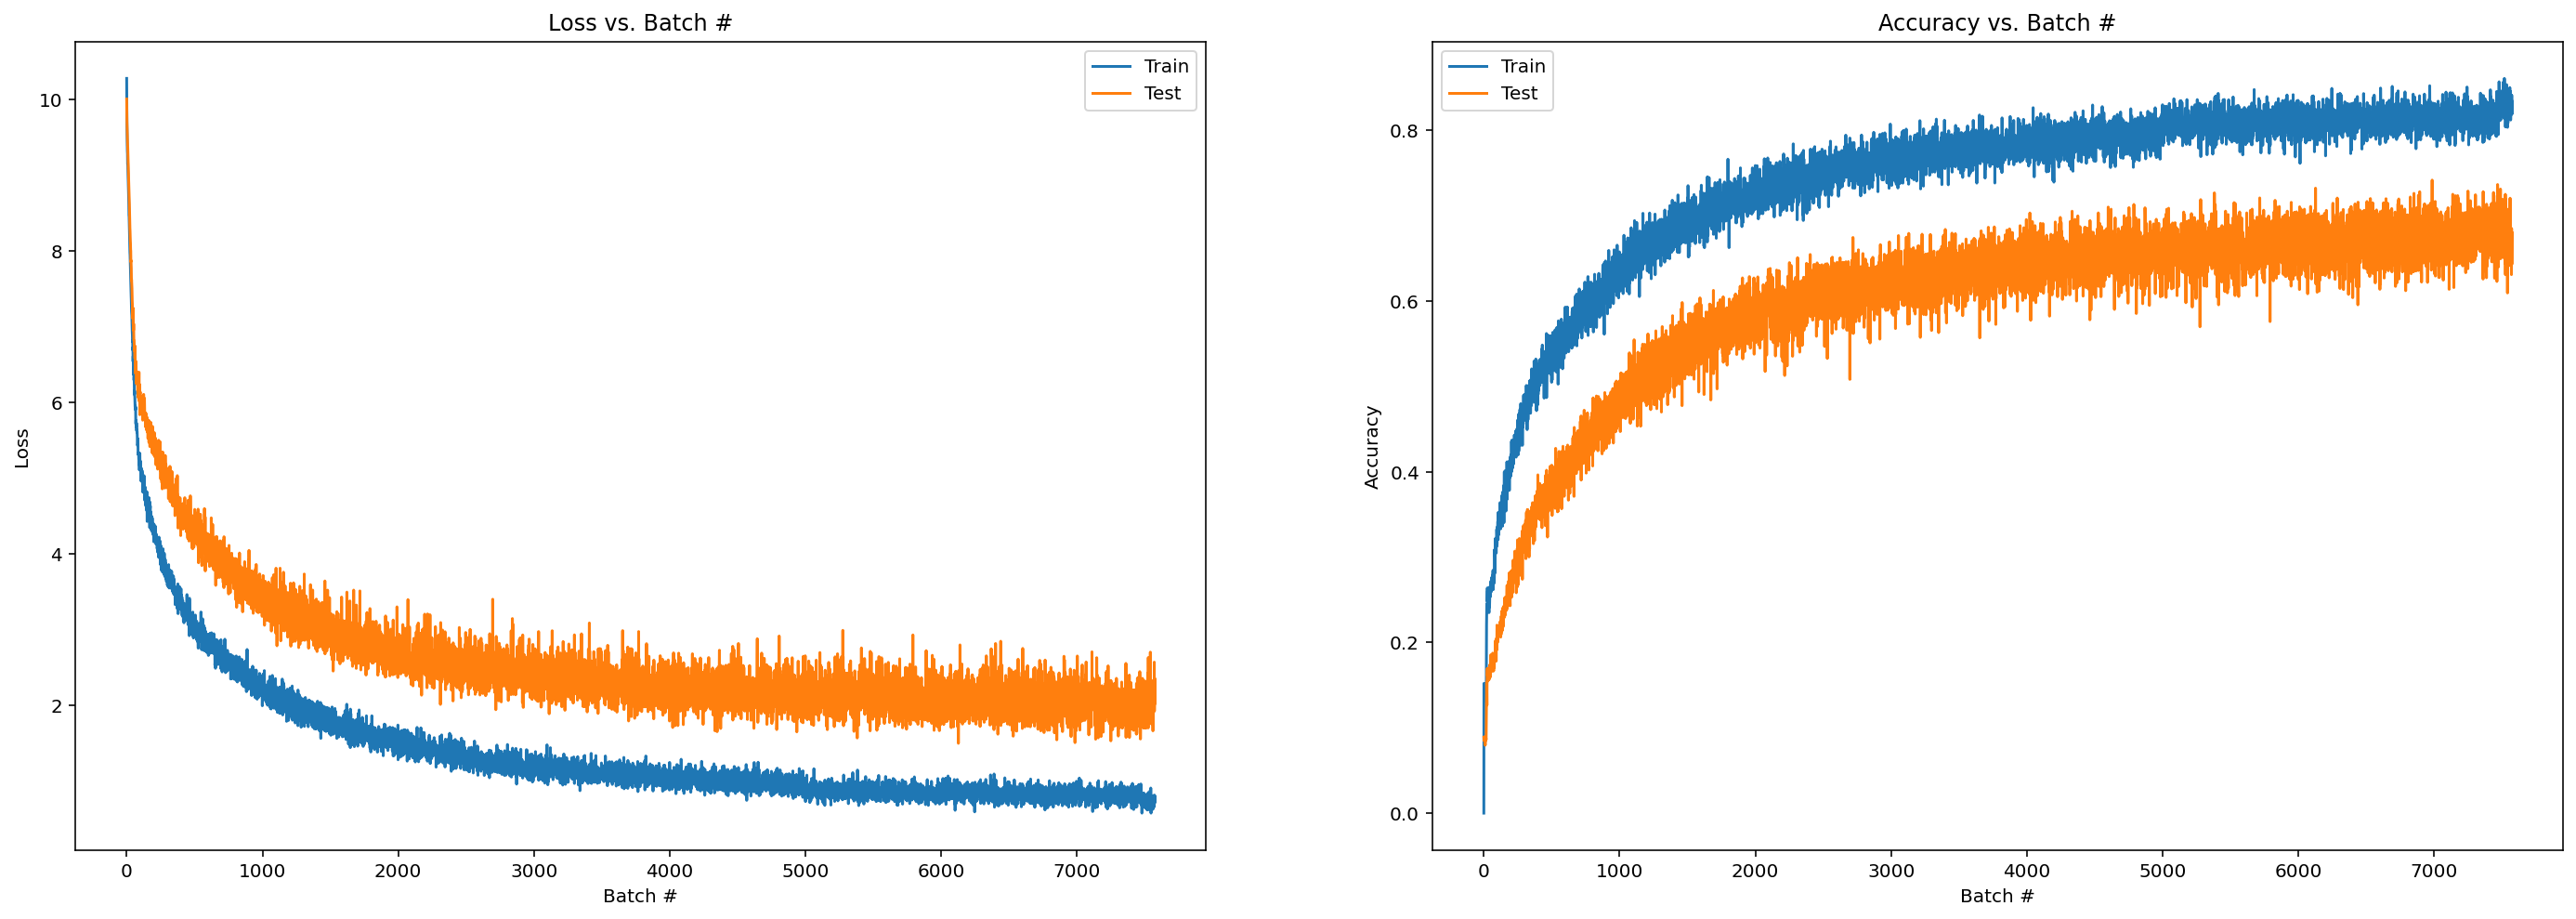

Epoch 4 of 5 | Progress: 141/2491 | Train Loss: 0.729 | Train Accuracy: 82.914% | Test Loss: 2.031 | Test Accuracy: 67.903% | Remaining Time: 48m 1.7s        

In [ ]:
history = train(epochs)

### Calculate Loss And Accuracy

In [ ]:
# calculate train batch losses and accuracies
train_losses, train_accuracies = [], []
for input_batch, target_batch in train_dataset:
  input_batch = input_vectorizer(input_batch)
  target_batch = target_vectorizer(target_batch)
  loss, acc = test_step(input_batch, target_batch)
  train_losses.append(loss)
  train_accuracies.append(acc)

# calculate test batch losses and accuracies
test_losses, test_accuracies = [], []
for input_batch, target_batch in test_dataset:
  input_batch = input_vectorizer(input_batch)
  target_batch = target_vectorizer(target_batch)
  loss, acc = test_step(input_batch, target_batch)
  test_losses.append(loss)
  test_accuracies.append(acc)

# average batch losses and accuracies
train_loss = np.mean(train_losses)
test_loss = np.mean(test_losses)
train_accuracy = np.mean(train_accuracies) * 100
test_accuracy = np.mean(test_accuracies) * 100

# print metrics
print(f'======== {model_name} metrics ========')
print(f'Train Loss: {train_loss:.3f}')
print(f'Test Loss: {test_loss:.3f}')
print(f'Train Accuracy: {train_accuracy:.3f}%')
print(f'Train Accuracy: {test_accuracy:.3f}%')

======== english_to_italian metrics ========
Train Loss: 0.669
Test Loss: 1.998
Train Accuracy: 83.674%
Train Accuracy: 67.629%


### Save Transformer

In [ ]:
tf.saved_model.save(transformer, f'{env_dir}/saved_models/{model_name}')

### Save Text Processors

In [ ]:
text_processors_dir = f'{env_dir}/text_processors/{model_name}'

make_dir(text_processors_dir)

save_layer_as_pickle(input_vectorizer, f'{text_processors_dir}/input_vectorizer.pkl')
save_layer_as_pickle(target_token_from_index, f'{text_processors_dir}/target_token_from_index.pkl')

### Save Training Metrics

In [ ]:
metrics_dir = f'{env_dir}/metrics/{model_name}'

make_dir(metrics_dir)

train_losses, test_losses, train_accuracies, test_accuracies = history

np.save(f'{metrics_dir}/train_losses.npy', train_losses)
np.save(f'{metrics_dir}/test_losses.npy', test_losses)
np.save(f'{metrics_dir}/train_accuracies.npy', train_accuracies)
np.save(f'{metrics_dir}/test_accuracies.npy', test_accuracies)

# Results

### Load Transformer

In [ ]:
model_name = 'chinese_to_english'

input_language, target_language = model_name.split('_to_')

transformer = tf.saved_model.load(f'{env_dir}/saved_models/{model_name}')

### Load Text Processors

In [ ]:
text_processors_dir = f'{env_dir}/text_processors/{model_name}'

input_vectorizer = load_pickle_as_layer(f'{text_processors_dir}/input_vectorizer.pkl', layers.TextVectorization)
target_token_from_index = load_pickle_as_layer(f'{text_processors_dir}/target_token_from_index.pkl', layers.StringLookup)

input_tokenizer = stanza.Pipeline(lang=language_codes[input_language], processors='tokenize')

INFO:stanza:"zh" is an alias for "zh-hans"
INFO:stanza:Loading these models for language: zh-hans (Simplified_Chinese):
| Processor | Package |
-----------------------
| tokenize  | gsdsimp |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Done loading processors!


### Define Translate Functions

In [ ]:
def translate(sentence, transformer, input_vectorizer, target_token_from_index, out_language=None, max_tokens=128, skip_tokenization=False, prettify=True):
  if not skip_tokenization:
    sentence = input_tokenizer(sentence)
    sentence = ' '.join([token.text.lower() for token in sentence.iter_tokens()])
  
  vec = input_vectorizer(sentence)[tf.newaxis]

  start_token_index = tf.constant(2, dtype=tf.int64)[tf.newaxis]
  end_token_index = tf.constant(3, dtype=tf.int64)[tf.newaxis]

  token_indices = [start_token_index]

  # iterate until end token is generated or max_tokens reached
  for i in range(max_tokens):
    target_indices = tf.transpose(tf.convert_to_tensor(token_indices))

    predictions, attention_scores = transformer([vec, target_indices], training=False)
    predictions = predictions[:, -1:, :]
    predicted_index = tf.argmax(predictions, axis=-1)

    token_indices.append(predicted_index[0])

    if predicted_index == end_token_index:
      break

  # convert indices to tokens
  tokens = [target_token_from_index(index)[0].numpy().decode() for index in token_indices[1:-1]]
  translation = ' '.join(tokens)

  # prettify translation
  if prettify:
    translation = prettify_translation(translation, out_language)

  return translation, attention_scores


def multi_translate(sentence, transformers, max_tokens=128):
  translation = sentence
  intermediates = []
  for i, (transformer, input_vectorizer, target_token_from_index, out_language) in enumerate(transformers):
    translation, _ = translate(translation, transformer, input_vectorizer,
                               target_token_from_index, out_language, max_tokens,
                               i!=0, i==(len(transformers)-1))
    
    if i < len(transformers) - 1:
      intermediates.append(prettify_translation(translation, out_language))
  
  return translation, intermediates


def combine_models(model_names):
  transformers = []
  input_vectorizers = []
  target_token_from_index_layers = []
  out_languages = []
  for model_name in model_names:
    transformers.append(tf.saved_model.load(f'{env_dir}/saved_models/{model_name}'))
    input_vectorizers.append(load_pickle_as_layer(f'{env_dir}/text_processors/{model_name}/input_vectorizer.pkl', layers.TextVectorization))
    target_token_from_index_layers.append(load_pickle_as_layer(f'{env_dir}/text_processors/{model_name}/target_token_from_index.pkl', layers.StringLookup))
    out_languages.append(model_name.split('_to_')[1])
  return list(zip(transformers, input_vectorizers, target_token_from_index_layers, out_languages))


def prettify_translation(translation, language=''):
  translation = re.sub(r' ([\'!?,.])', r'\1', translation)
  translation = translation.replace(' n\'t', 'n\'t')
  translation = translation.capitalize()

  no_space_languages = ['chinese', 'japanese', 'korean']

  if language in no_space_languages:
    translation = translation.replace(' ', '')
  
  return translation.capitalize()


def plot_attention_weights(sentence, translation, attention_heads):
  in_tokens = sentence.split()
  translated_tokens = translation.split()

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)
    plot_attention_head(in_tokens, translated_tokens, head)
    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()


def plot_attention_head(in_tokens, translated_tokens, attention):
  translated_tokens = translated_tokens + ['[END]']

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  ax.set_xticklabels(in_tokens, rotation=90)
  ax.set_yticklabels(translated_tokens)

### Translate Sentences From Test Set

In [ ]:
input_batch, target_batch = test_dataset.as_numpy_iterator().next()

input_batch = input_batch[:10]
target_batch = target_batch[:10]

preds = []
for input in input_batch:
  translation, _ = translate(input, transformer, input_vectorizer, target_token_from_index, skip_tokenization=True)
  preds.append(translation)

input_batch = [prettify_translation(text.decode()) for text in input_batch]
target_batch = [prettify_translation(text.decode()) for text in target_batch]
target_batch = [text.replace('[start] ', '').replace(' [end]', '') for text in target_batch]

pd.DataFrame({'input': input_batch,'prediction': preds, 'target': target_batch})

,input,prediction,target
0,"The instant he opened the door, he smelt somet...",वह उस आदमी को अपनी टीचर से ज़्यादा से ही है ।,उसे दरवाज़ा खोलते ही किसी चीज़ के जलने की बदबू...
1,"Nobody likes him, because he is always blowing...",कोई नहीं और वह हमेशा काले कपड़े पहनती है ।,उसे कोई भी पसंद नहीं करता क्योंकि वह सारे टाईम...
2,A selfish man thinks of nothing but his own fe...,एक आदमी ने उसकी आदमी को उसकी आदमी के लिए बहुत ...,मतलबी इनसान केवल अपनी भावनाओं के बारे में ही स...
3,Mother teresa was a catholic nun who lived and...,माँ ने माँ में बहुत सारे पैसे चुराने के लिए था ।,मदर टेरेसा एक कैथोलिक नन थीं जो कलकत्ता में रह...
4,It's an absolute waste of time to wait any lon...,यह सरासर समय की वजह से बहुत सारे है ।,और इंतेज़ार करना समय की सरासर बर्बादी होगी ।
5,"In order to stay awake, i may have to drink mo...",उन सभी की बात में मैं बहुत ही हूँ ।,मुझे जगे रहने के लिए शायद और कॉफ़ी पीनी पड़ेगी ।
6,Many people around the world don't have access...,"कई बार और कुछ लोगों को देखने में हैं, बहुत सार...",दुनिया भर में बहुत से लोगों को अच्छा पानी उपलब...
7,I'll arrange for someone to pick you up at you...,मैं तुम्हारे लिए घर में फ़ोन करूँगा ।,मैं किसी को तुम्हें घर से लेने के लिए भिजवादूँ...
8,We have some new products we'd like you to see.,हमारे पास कुछ बताने की आदत है ।,आपको कुछ नए प्रॉडक्ट्स दिखाना चाहते हैं ।
9,His shoes were so old that his toes were stick...,उसकी अपने पुराने कपड़ो पर उसका जन्मदिन था ।,उसके जूते इतने पुराने थे कि उनमें से उसकी ऊँगल...


### Translate Custom Text

In [ ]:
text = '''
I do not want to watch television anymore.
I want to go play outside!
'''

text = text.strip().split('\n')
for line in text:
  translation, attention_scores = translate(line, transformer, input_vectorizer, target_token_from_index, target_language)
  print(translation)

Δε θέλω να παρακολουθήσω τηλεόραση πια.
Θέλω να πάω έξω!


### Plot Attention Heads

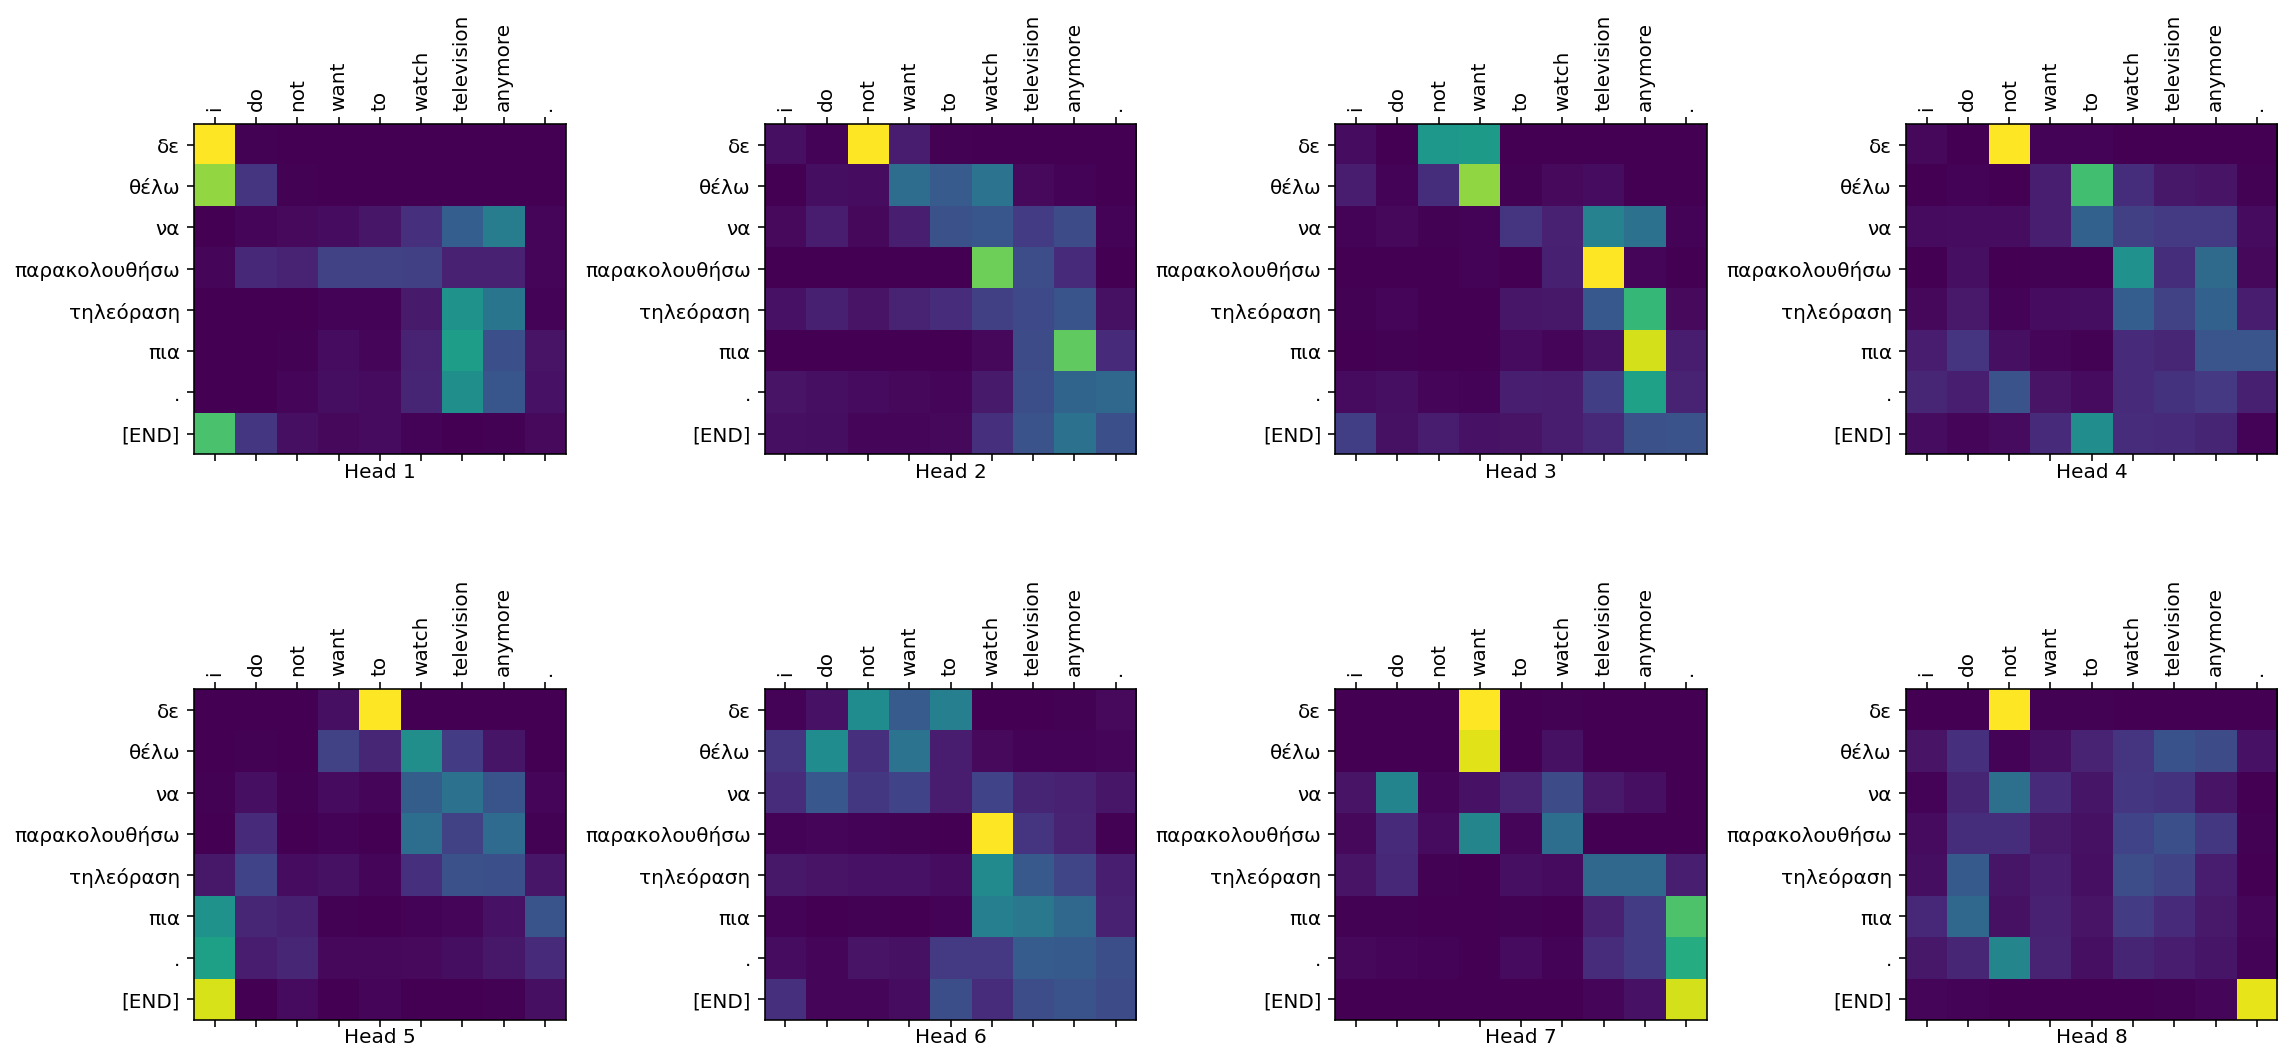

In [ ]:
text = 'I do not want to watch television anymore.'
text = input_tokenizer(text.lower())
text = ' '.join([token.text for token in text.iter_tokens()])

translation, attention_scores = translate(text, transformer, input_vectorizer, target_token_from_index, target_language, prettify=False)

plot_attention_weights(text, translation, attention_scores[0][0])

### Combine Multiple Translators

In [ ]:
models = ['english_to_romanian', 'romanian_to_english']

transformers = combine_models(models)

input_vectorizer = load_pickle_as_layer(f'{env_dir}/text_processors/{models[0]}/input_vectorizer.pkl', layers.TextVectorization)
target_token_from_index = load_pickle_as_layer(f'{env_dir}/text_processors/{models[-1]}/target_token_from_index.pkl', layers.StringLookup)

input_tokenizer = stanza.Pipeline(lang=language_codes[models[0].split('_to_')[0]], processors='tokenize')

INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Done loading processors!


### Translate Using Multiple Translators

In [ ]:
text = '''
Today is Tuesday.
'''

show_intermediates = True

text = text.strip().split('\n')
for line in text:
  translation, intermediates = multi_translate(line, transformers)
  if show_intermediates:
    intermediates = ' >>> '.join(intermediates)
    print(f'{line} >>> {intermediates} >>> {translation}')
  else:
    print(translation)

Today is Tuesday. >>> Azi e sâmbătă. >>> Today is saturday.
